# Single cell proteomics pipeline
#### **Author:** Gerard Font Juvanteny
_MBDS - Master Biomedical Data Science_


---
### Import required libraries


In [6]:
import pandas as pd
from src.data.dea import differential_expression_analysis
from src.string_client import StringClient

# Import PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from igraph import Graph, plot
from Bio import SeqIO
import os



**Setup logs**

---
### Set parameters / constants


In [7]:
# Path to the data
PATH_DATA = './data/processed/2021_Leduc/'
NAME_EXPERIMENT = '2021_Leduc'


---
### Prepare data according the input format

In [8]:
# Load the data from the CSV file
prot_intensity = pd.read_csv(PATH_DATA + 'prot_proc.csv')
# Rename the first column to 'protein'
prot_intensity = prot_intensity.rename(columns={'Unnamed: 0': 'protein'})
# Convert the first column to the index of the DataFrame
prot_intensity = prot_intensity.set_index('protein')

# Load the data from the CSV file
metadata = pd.read_csv(PATH_DATA + 'anno.csv')
# Convert the first column of metadata to the index of the DataFrame
metadata = metadata.set_index('Unnamed: 0')
# Replace the column names with the values of the first row
metadata.columns = metadata.iloc[0]
# Drop the first row from the metadata DataFrame
metadata = metadata.drop(metadata.index[0])


# Concatenate the metadata to the protein intensity data frame
# TODO: We assume that both data frames have the same order for the columns
prot_intensity = pd.concat([metadata, prot_intensity], axis=0, ignore_index=False)
print(prot_intensity.head())

                 i10      i102      i103      i104      i105      i106  \
celltype           H         U         U         U         H         H   
A0A024RBG1 -0.208326  0.317744   0.29467  0.381682 -0.187703 -0.267211   
A0A1B0GX78  0.195591 -0.122598 -0.627951  0.132455  0.153521  0.244738   
A0AVF1     -0.795366  0.114473  0.185542  0.258208 -0.260679  0.148852   
A1A4S6     -0.152512  0.060963  0.885153  0.314711 -0.345838 -0.549751   

                i107      i108      i109       i11  ...       i87       i88  \
celltype           H         H         H         H  ...         U         H   
A0A024RBG1 -0.103692 -0.264988  -0.35848 -0.366581  ...  0.542687 -0.493343   
A0A1B0GX78 -0.364624 -0.074277  0.251052  0.049257  ...  0.045749  0.271147   
A0AVF1      0.402998 -0.305016  0.323643 -0.425968  ... -0.032475  0.106257   
A1A4S6     -0.202808  0.021079 -0.307785  0.359791  ...  0.143857 -0.691573   

                 i89        i9       i90       i91       i92       i93  \
cellty



---
### Statistic analysis

**Perform a PCA**

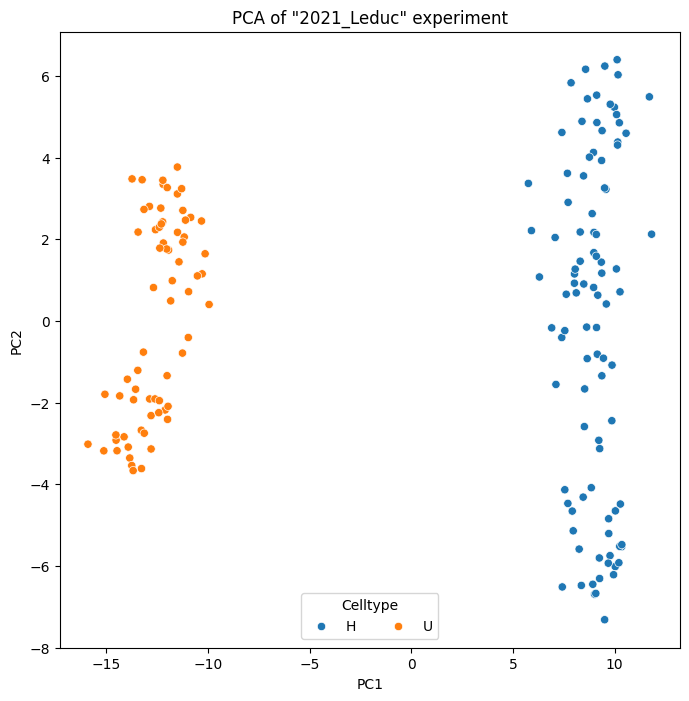

In [9]:
# Perform a PCA 
pca = PCA(n_components=2)

# Transpose the data
pca_data = prot_intensity.T

X = pca_data.iloc[:, 1:]
Y = pca_data.iloc[:, 0]

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDf.index = pca_data.index

# Concatenate the 1st row of prot_intensity to the principalDf
pca_df = pd.concat([principalDf , Y], axis=1)

# Plot the PCA and place the in the upper center, including the title "Celltype" for the lagend
plt.figure(figsize=(8, 8))
plt.title('PCA of "{0}" experiment'.format(NAME_EXPERIMENT))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='celltype')
plt.legend(title='Celltype', loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=3)
plt.show()



**Differential Expression Analysis**

In [10]:
#import pandas as pd
#from pyDESeq2 import py_DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats


# Read your proteomics data from a CSV file
data = prot_intensity

# Assume the first row contains the sample conditions
conditions = data.iloc[0, :]
data = data.iloc[1:, :]

# Create a sample information DataFrame
sample_info = pd.DataFrame({
    'condition': conditions.values
}, index=conditions.index)

# Ensure the data is numeric
data = data.astype(float)

dataT = data.T

dataT



,A0A024RBG1,A0A1B0GX78,A0AVF1,A1A4S6,A4D0S4,A4FU69,A6H8Y1,A6NFK2,A6NFN9,A6NGR9,...,Q9Y5Q8,Q9Y5S9,Q9Y5W9,Q9Y613,Q9Y617,Q9Y653,Q9Y6C2,Q9Y6D6,Q9Y6V7,Q9Y6W6
i10,-0.208326,0.195591,-0.795366,-0.152512,-0.083936,0.262566,-0.330972,0.684506,0.970011,-0.880989,...,1.362794,-0.090204,-0.131163,-0.119977,0.226318,-0.690882,-0.401693,0.037418,0.623751,-0.188457
i102,0.317744,-0.122598,0.114473,0.060963,0.287396,0.097426,0.579381,1.443848,-0.996630,1.202588,...,-1.386451,-0.651874,0.216465,0.208050,0.122046,0.760929,0.620840,-0.217755,-0.581454,0.466771
i103,0.294670,-0.627951,0.185542,0.885153,0.297342,0.107372,0.727271,1.453794,-0.943628,-0.052100,...,-1.544113,-0.149517,0.226411,0.295929,0.016276,0.002901,1.141135,-0.718330,1.148661,-0.218439
i104,0.381682,0.132455,0.258208,0.314711,0.283589,0.093619,0.713518,1.440041,-1.500282,0.624641,...,-1.390258,-0.456611,0.105575,0.282177,-0.380140,0.913847,0.389539,-0.221562,-0.094485,0.255493
i105,-0.187703,0.153521,-0.260679,-0.345838,-0.184337,-0.025293,-0.327262,-1.190058,0.060566,0.064436,...,0.997089,0.340324,-0.119809,-0.113611,0.257238,-0.167611,-0.605469,0.320013,-0.147216,-0.262513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i91,0.098455,-0.281758,0.554599,-0.024398,-0.143244,-0.044526,-0.742871,-1.204864,0.362694,0.291378,...,0.870132,-0.299431,-0.111069,-0.228879,-0.287223,-0.076857,-0.178269,-0.047696,0.251044,0.009349
i92,-0.098816,0.300637,0.221405,0.040576,-0.165704,-0.066987,-0.357370,-1.184731,0.830720,0.895522,...,0.847672,-0.204721,-0.133530,-0.015870,0.248598,0.114993,-0.684635,0.435420,0.923334,-0.181125
i93,-0.178695,0.177504,-0.304254,0.297166,-0.217730,-0.061660,-0.040380,-1.179404,1.262447,0.670092,...,0.985219,0.756135,-0.128203,-0.036485,-0.624574,0.281783,-0.596074,0.440746,0.036995,-0.222894
i95,0.218688,-0.206167,-0.225676,0.331204,0.345015,0.136336,0.020634,1.428992,-1.228872,0.552391,...,-1.324809,-0.652762,0.098110,0.208554,0.175804,0.462913,0.739275,-0.470684,-0.178616,0.460165


In [11]:

# Initialize the DESeq2 object
#dds = py_DESeq2(count_matrix=data, design_matrix=sample_info, design_formula='~ condition')

# Perform the DESeq2 analysis
#dds.run_deseq()

# Get the results
#results = dds.get_results()

# Print the results
#print(results)



---
#### Functional Enrichment Analysis

In [12]:
data

,i10,i102,i103,i104,i105,i106,i107,i108,i109,i11,...,i87,i88,i89,i9,i90,i91,i92,i93,i95,i96
A0A024RBG1,-0.208326,0.317744,0.294670,0.381682,-0.187703,-0.267211,-0.103692,-0.264988,-0.358480,-0.366581,...,0.542687,-0.493343,-0.106477,0.297865,-0.373612,0.098455,-0.098816,-0.178695,0.218688,0.134222
A0A1B0GX78,0.195591,-0.122598,-0.627951,0.132455,0.153521,0.244738,-0.364624,-0.074277,0.251052,0.049257,...,0.045749,0.271147,0.204955,0.549689,-0.346616,-0.281758,0.300637,0.177504,-0.206167,-0.690147
A0AVF1,-0.795366,0.114473,0.185542,0.258208,-0.260679,0.148852,0.402998,-0.305016,0.323643,-0.425968,...,-0.032475,0.106257,-0.038431,0.041050,0.207227,0.554599,0.221405,-0.304254,-0.225676,-0.218771
A1A4S6,-0.152512,0.060963,0.885153,0.314711,-0.345838,-0.549751,-0.202808,0.021079,-0.307785,0.359791,...,0.143857,-0.691573,-0.201892,0.601926,-0.669140,-0.024398,0.040576,0.297166,0.331204,0.913169
A4D0S4,-0.083936,0.287396,0.297342,0.283589,-0.184337,-0.246598,-0.179197,-0.255501,-0.261934,-0.196996,...,-0.010474,-0.149900,-0.272791,0.228956,-0.159356,-0.143244,-0.165704,-0.217730,0.345015,-0.019171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y653,-0.690882,0.760929,0.002901,0.913847,-0.167611,0.081522,-0.536611,-0.001761,-0.078034,-0.044077,...,-0.277291,-0.390146,-0.072569,0.071007,-0.197536,-0.076857,0.114993,0.281783,0.462913,0.448774
Q9Y6C2,-0.401693,0.620840,1.141135,0.389539,-0.605469,-0.602603,-0.600329,-0.611506,-0.439348,-0.711219,...,0.846598,-0.186852,-0.895863,0.776669,-0.595053,-0.178269,-0.684635,-0.596074,0.739275,1.103247
Q9Y6D6,0.037418,-0.217755,-0.718330,-0.221562,0.320013,0.323589,0.325153,0.314686,0.308253,0.595893,...,-0.476704,-0.110589,0.456469,0.113090,0.441768,-0.047696,0.435420,0.440746,-0.470684,-0.239526
Q9Y6V7,0.623751,-0.581454,1.148661,-0.094485,-0.147216,-0.187868,-0.136240,-0.252599,-0.940300,0.056377,...,-0.160671,-0.382408,-0.618493,-0.355252,0.580055,0.251044,0.923334,0.036995,-0.178616,-0.697564



---
#### StringDB

In [13]:
sdb = StringClient(server_url="https://string-db.org/api", output_format="tsv-no-header", method="network", species=9606, score_threshold=400)

In [14]:
proteins = data.index.tolist()
proteins = proteins[:50]

In [15]:
# Map proteins to STRING IDs
mapped_proteins = sdb.map_proteins(proteins)
 
# Parse the STRING interactions
interactions = []
for line in mapped_proteins.strip().split("\n"):
    parts = line.split("\t")
    if len(parts) >= 5:
        interactions.append((parts[0], parts[1], float(parts[5])))

mapped_proteins

'9606.ENSP00000217971\t9606.ENSP00000442047\tPGRMC1\tUTY\t9606\t0.422\t0\t0\t0\t0\t0\t0\t0.423\n9606.ENSP00000261574\t9606.ENSP00000370589\tIPO5\tNOP56\t9606\t0.408\t0\t0\t0\t0.378\t0.062\t0\t0.067\n9606.ENSP00000261574\t9606.ENSP00000473383\tIPO5\tFBLL1\t9606\t0.47\t0\t0\t0\t0.341\t0.091\t0\t0.186\n9606.ENSP00000301067\t9606.ENSP00000494040\tKMT2D\tDDX3X\t9606\t0.504\t0\t0\t0\t0.065\t0.051\t0\t0.486\n9606.ENSP00000301067\t9606.ENSP00000442047\tKMT2D\tUTY\t9606\t0.848\t0\t0\t0\t0.073\t0.496\t0.54\t0.378\n9606.ENSP00000342812\t9606.ENSP00000494040\tUSP9Y\tDDX3X\t9606\t0.619\t0\t0\t0\t0.061\t0.126\t0\t0.573\n9606.ENSP00000342812\t9606.ENSP00000442047\tUSP9Y\tUTY\t9606\t0.999\t0\t0\t0\t0.999\t0\t0\t0.983\n9606.ENSP00000356155\t9606.ENSP00000381034\tPIK3C2B\tSOCS6\t9606\t0.57\t0\t0\t0\t0.064\t0\t0.54\t0.083\n9606.ENSP00000370589\t9606.ENSP00000473383\tNOP56\tFBLL1\t9606\t0.994\t0\t0\t0\t0.833\t0.838\t0.54\t0.642\n9606.ENSP00000431800\t9606.ENSP00000448035\tEIF3F\tNACA\t9606\t0.536\t0\t0\t0

In [16]:
interactions

[('9606.ENSP00000217971', '9606.ENSP00000442047', 0.422),
 ('9606.ENSP00000261574', '9606.ENSP00000370589', 0.408),
 ('9606.ENSP00000261574', '9606.ENSP00000473383', 0.47),
 ('9606.ENSP00000301067', '9606.ENSP00000494040', 0.504),
 ('9606.ENSP00000301067', '9606.ENSP00000442047', 0.848),
 ('9606.ENSP00000342812', '9606.ENSP00000494040', 0.619),
 ('9606.ENSP00000342812', '9606.ENSP00000442047', 0.999),
 ('9606.ENSP00000356155', '9606.ENSP00000381034', 0.57),
 ('9606.ENSP00000370589', '9606.ENSP00000473383', 0.994),
 ('9606.ENSP00000431800', '9606.ENSP00000448035', 0.536),
 ('9606.ENSP00000431800', '9606.ENSP00000494040', 0.651),
 ('9606.ENSP00000442047', '9606.ENSP00000494040', 0.811),
 ('9606.ENSP00000466214', '9606.ENSP00000481842', 0.421)]

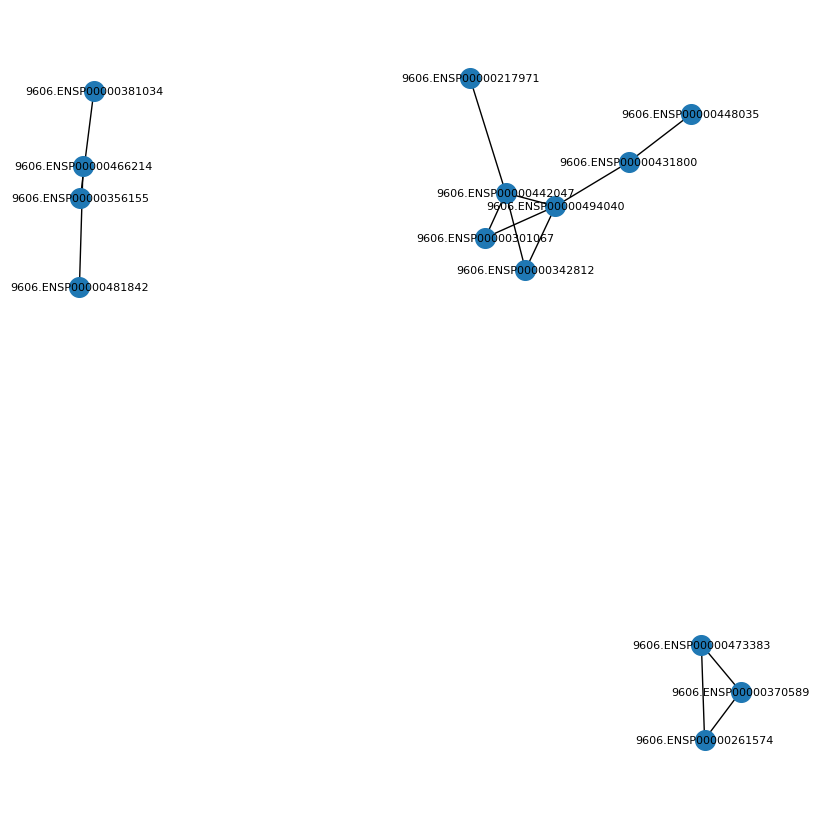

In [17]:
# Create an networkx object from the interactions
import networkx as nx
G = nx.Graph()
G.add_weighted_edges_from(interactions)


# Plot the network
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=200, width=1)
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, font_size=8)
plt.show()
